In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as mx
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split,KFold, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import roc_curve, plot_roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report,RocCurveDisplay,auc
from sklearn.svm import SVC, LinearSVC, NuSVC, SVR, NuSVR, LinearSVR
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection
from sklearn.preprocessing import scale 

from numpy import mean, std

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.inspection import permutation_importance


In [35]:
ALL=pd.read_table('healthytpm.txt', sep=',')
TSV=pd.read_table('gdc_sample_sheet.2022-09-20.Tum.tsv')
UID=pd.read_table('gdc_manifest_20220920_155722.txt')
PrimaryTumour=TSV[TSV['Sample Type']=='Primary Tumor']
PrimaryTumour=TSV[TSV['Sample Type']=='Primary Tumor']
MatchedCon=TSV[TSV['Sample Type']=='Solid Tissue Normal'].sort_values(by='Case ID')
MatchedCase=PrimaryTumour.loc[PrimaryTumour['Case ID'].isin(MatchedCon['Case ID'])].sort_values(by='Case ID')

In [36]:
H_ID=MatchedCon['File Name']
T_ID=MatchedCase['File Name']
con=ALL[H_ID]
tumour=ALL[T_ID]
con.columns=MatchedCon['Case ID']
con.index=ALL['gene_id']
tumour.columns=MatchedCase['Case ID']
tumour.index=ALL['gene_id']

In [37]:
T=tumour.T
T['Group']=1
C=con.T
C['Group']=0
full_data=pd.concat([C, T], axis=0)


In [38]:
full_data

gene_id,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1,Group
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-BC-A10Q,46.8388,0.0335,32.8076,2.9483,0.5707,4.2776,359.9613,27.1020,36.6102,5.6229,...,0.0,0.0433,0.0,0.0000,0.1486,6.1480,0.0,0.0154,0.0588,0
TCGA-BC-A10R,40.7921,0.6344,36.3942,4.0135,0.3422,8.2186,441.5682,29.9106,40.5900,5.3277,...,0.0,0.0149,0.0,0.0000,0.2028,6.9019,0.0,0.0221,0.1774,0
TCGA-BC-A10T,35.7484,0.0000,28.8150,3.7478,0.4119,2.9382,248.6657,23.0128,30.1717,5.5837,...,0.0,0.0088,0.0,1.6455,0.0755,7.8322,0.0,0.0209,0.0000,0
TCGA-BC-A10U,42.4380,0.0000,37.4583,3.4585,0.3170,3.4696,290.1571,27.1841,32.8977,5.8932,...,0.0,0.0221,0.0,0.0000,0.0738,5.4231,0.0,0.0175,0.0250,0
TCGA-BC-A10W,46.7263,0.0296,35.3377,1.7605,0.5935,3.3890,281.7136,44.7538,29.8376,4.4768,...,0.0,0.0461,0.0,0.0000,0.4060,3.8735,0.0,0.0136,0.1562,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-FV-A2QR,123.3864,0.0000,76.3030,7.1504,3.8938,4.0080,625.8295,18.6297,24.8572,9.2078,...,0.0,0.0556,0.0,0.0000,0.0000,36.1748,0.0,0.0329,0.4524,1
TCGA-FV-A3I0,260.5306,0.0000,83.2286,5.5850,1.5653,3.9353,5.7132,51.4775,12.5685,37.7655,...,0.0,0.3602,0.0,0.0000,0.0000,11.6750,0.0,0.0368,0.3793,1
TCGA-FV-A3I1,102.5488,0.0000,46.1930,6.2951,3.4402,6.9674,748.4068,114.7792,27.9926,21.9619,...,0.0,0.1243,0.0,0.0000,0.0000,10.9026,0.0,0.0803,0.4216,1


In [39]:
Y=full_data.iloc[:,full_data.columns == 'Group']
X=full_data.iloc[:,full_data.columns != 'Group']

In [40]:
from sklearn.model_selection import train_test_split

X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size= 0.20, random_state=1303,stratify=Y,shuffle = True)


In [41]:
X_tr[['ENSG00000255823.5','ENSG00000087086.15','ENSG00000163736.4','ENSG00000205542.11','ENSG00000163191.6',
      'ENSG00000163220.11','ENSG00000075624.17']]
#,'ENSG00000131149.19','ENSG00000131002.12'

gene_id,ENSG00000255823.5,ENSG00000087086.15,ENSG00000163736.4,ENSG00000205542.11,ENSG00000163191.6,ENSG00000163220.11,ENSG00000075624.17
Case ID,,,,,,,
TCGA-DD-A116,0.6458,16354.2991,0.0290,366.6772,78.4900,49.1536,615.9923
TCGA-DD-A1EI,0.8806,12727.7386,0.2033,470.5326,69.6534,14.1091,784.8307
TCGA-DD-A118,1.0085,18243.9153,2.3631,486.6031,78.8919,120.1392,698.7096
TCGA-FV-A23B,1.3799,16791.6416,0.3575,822.7874,132.4884,50.4158,1100.2297
TCGA-BC-A10U,0.8132,8430.9853,0.2896,436.9524,110.8798,53.2146,1147.0198
...,...,...,...,...,...,...,...
TCGA-DD-A1EB,3.0530,18001.9920,0.2107,446.0265,78.0826,139.5479,1042.8515
TCGA-DD-A113,2.3680,27181.9144,0.6145,338.8559,60.7887,52.7336,1191.2149
TCGA-BD-A2L6,1.4202,13396.4669,0.1720,786.2914,84.5976,15.1739,1171.6569


In [43]:
Xtr_filtered=X_tr[['ENSG00000255823.5','ENSG00000087086.15','ENSG00000163736.4','ENSG00000205542.11','ENSG00000163191.6',
                   'ENSG00000163220.11','ENSG00000075624.17']]
#,'ENSG00000131149.19','ENSG00000131002.12'
Xtr_filtered=Xtr_filtered.fillna(0)

In [44]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer()
Xtr_filtered_S= transformer.fit_transform(Xtr_filtered)

In [45]:
def modelPerformance(confMat):
    TN = confMat[0, 0]
    TP = confMat[1, 1]
    FP = confMat[0, 1]
    FN = confMat[1, 0]
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    spec = TN / (TN + FP)
    fpr = FP / (TN + FP)
    f1 = 2 * (prec * rec) / (prec + rec)
    acc = (TP + TN) / (TP + FP + TN + FN)
    return (acc, prec, rec, spec, fpr, f1)

def printPerformance(confMat):
    acc, prec, rec, spec, fpr, f1 = modelPerformance(confMat)
    print("Accuracy = " "%.4f" % acc)
    print("Precision = " "%.4f" % prec)
    print("Recall = " "%.4f" % rec)
    print("Specificity = " "%.4f" % spec)
    print("False positive rate = " "%.4f" % fpr)
    print("F1-score = " "%.4f" % f1)
    np.set_printoptions(precision=2)
    print("Confusion matrix (%):")
    print(confMat/np.sum(confMat)*100)

In [46]:
param_grid_SVC = {'C': np.logspace(-2, 10, 13), 
              'random_state':[1303],
              'kernel':['linear','poly','rbf','sigmoid'],
              'gamma':['scale','auto']}

gridcv = GridSearchCV(SVC(), param_grid_SVC, refit=True, cv=5, verbose=1, n_jobs=-1)


# fit the model for grid search 
gridcv.fit(Xtr_filtered_S, Y_tr) 
 
# display best parameters after tuning 
display(gridcv.best_params_) 
gridcv.best_score_

Fitting 5 folds for each of 104 candidates, totalling 520 fits


C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1000000.0, 'gamma': 'scale', 'kernel': 'poly', 'random_state': 1303}

0.8875

0.9
0.8875


C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is depre

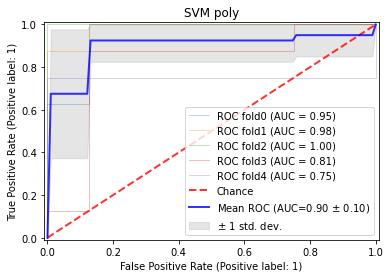

In [47]:
clfSVC = gridcv.best_estimator_


cv = StratifiedKFold(n_splits=5)
scores = ('accuracy','roc_auc')
output = pd.DataFrame(cross_validate(clfSVC, Xtr_filtered_S, Y_tr, scoring=scores, cv=cv, n_jobs=-1))
print(mean(output['test_roc_auc']))
print(mean((output['test_accuracy'])))

tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
cv = StratifiedKFold(n_splits=5)
fig,ax=plt.subplots()
for i, (train, test) in enumerate(cv.split(Xtr_filtered_S, Y_tr)):
    
    clfSVC.fit(Xtr_filtered_S[train],Y_tr.iloc[list(train)].values.ravel())
    vis=plot_roc_curve(clfSVC, Xtr_filtered_S[test],Y_tr.iloc[list(test)], name='ROC fold{}'.format(i),alpha=0.3,lw=1,ax=ax)
   
    tprs.append(np.interp(mean_fpr, vis.fpr, vis.tpr))
    tprs[-1][0]=0.0
    aucs.append(vis.roc_auc)
   
ax.plot([0,1],[0,1],linestyle='--', lw=2, color='r', label = 'Chance', alpha = 0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1]=1
mean_auc=auc(mean_fpr,mean_tpr)
std_auc=np.std(aucs)
ax.plot(mean_fpr,mean_tpr,color='b', label=r'Mean ROC (AUC=%0.2f $\pm$ %0.2f)' %(mean_auc,std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper,color='grey',alpha= 0.2, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01,1.01],ylim=[-0.01,1.01],title="SVM poly")
ax.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100, 200),
 'max_iter': 200,
 'random_state': 1303,
 'solver': 'lbfgs'}

C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

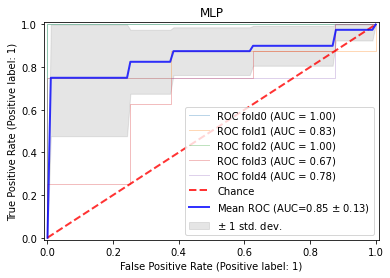

In [51]:
parameters = {'solver': ['lbfgs','adam','sgd'], 'max_iter': [200], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':[(100,200)] ,'random_state':[1303], 'activation':['tanh','relu','logistic']}


gridcv = GridSearchCV(MLPClassifier(), parameters, refit=True, cv=5, verbose=1, n_jobs=-1)


# fit the model for grid search 
gridcv.fit(Xtr_filtered_S, Y_tr) 
 
# display best parameters after tuning 
display(gridcv.best_params_) 

mlp = gridcv.best_estimator_
tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
cv = StratifiedKFold(n_splits=5)
fig,ax=plt.subplots()
for i, (train, test) in enumerate(cv.split(Xtr_filtered_S, Y_tr)):
    
    mlp.fit(Xtr_filtered_S[train],Y_tr.iloc[list(train)].values.ravel()).predict_proba(Xtr_filtered_S[test])
    vis=plot_roc_curve(mlp, Xtr_filtered_S[test],Y_tr.iloc[list(test)], name='ROC fold{}'.format(i),alpha=0.3,lw=1,ax=ax)
   
    tprs.append(np.interp(mean_fpr, vis.fpr, vis.tpr))
    tprs[-1][0]=0.0
    aucs.append(vis.roc_auc)
   
ax.plot([0,1],[0,1],linestyle='--', lw=2, color='r', label = 'Chance', alpha = 0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1]=1
mean_auc=auc(mean_fpr,mean_tpr)
std_auc=np.std(aucs)
ax.plot(mean_fpr,mean_tpr,color='b', label=r'Mean ROC (AUC=%0.2f $\pm$ %0.2f)' %(mean_auc,std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper,color='grey',alpha= 0.2, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01,1.01],ylim=[-0.01,1.01],title="MLP")
ax.legend(loc="lower right")
plt.show()

Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'class_weight': 'balanced_subsample',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is depre

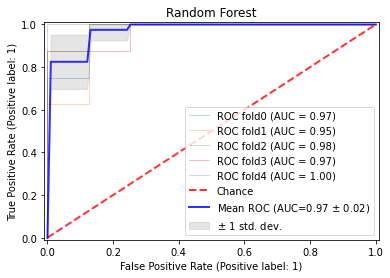

In [52]:
n_estimators = [ 200, 1000, 7000]
max_depth = [5, 8]
min_samples_split = [2, 5, 15]
min_samples_leaf = [1, 2, 5] 
class_weight=['balanced_subsample']
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf,class_weight=class_weight)

gridF = GridSearchCV(RandomForestClassifier(random_state = 1303), hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(Xtr_filtered_S, Y_tr)
display(bestF.best_params_) 

bestF=bestF.best_estimator_

tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
cv = StratifiedKFold(n_splits=5)
fig,ax=plt.subplots()
for i, (train, test) in enumerate(cv.split(Xtr_filtered_S, Y_tr)):
    
    bestF.fit(Xtr_filtered_S[train],Y_tr.iloc[list(train)].values.ravel())
    vis=plot_roc_curve(bestF, Xtr_filtered_S[test],Y_tr.iloc[list(test)], name='ROC fold{}'.format(i),alpha=0.3,lw=1,ax=ax)
   
    tprs.append(np.interp(mean_fpr, vis.fpr, vis.tpr))
    tprs[-1][0]=0.0
    aucs.append(vis.roc_auc)
   
ax.plot([0,1],[0,1],linestyle='--', lw=2, color='r', label = 'Chance', alpha = 0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1]=1
mean_auc=auc(mean_fpr,mean_tpr)
std_auc=np.std(aucs)
ax.plot(mean_fpr,mean_tpr,color='b', label=r'Mean ROC (AUC=%0.2f $\pm$ %0.2f)' %(mean_auc,std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper,color='grey',alpha= 0.2, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01,1.01],ylim=[-0.01,1.01],title="Random Forest")
ax.legend(loc="lower right")
plt.show()


Fitting 5 folds for each of 169 candidates, totalling 845 fits


C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10000000000.0, 'random_state': 1303, 'tol': 0.01}

C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is depre

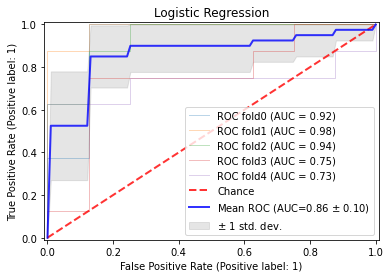

In [54]:
from sklearn.linear_model import LogisticRegression

parameters = {'C': np.logspace(-2, 10, 13), 
              'random_state':[1303],
              'tol':np.logspace(-2, 10, 13)}


gridL = GridSearchCV(LogisticRegression(), parameters, cv = 5, verbose = 1, n_jobs = -1)
bestL = gridL.fit(Xtr_filtered_S, Y_tr)
display(bestL.best_params_) 
bestL.best_score_
LogReg=bestL.best_estimator_

tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
cv = StratifiedKFold(n_splits=5)
fig,ax=plt.subplots()
for i, (train, test) in enumerate(cv.split(Xtr_filtered_S, Y_tr)):
    
    LogReg.fit(Xtr_filtered_S[train],Y_tr.iloc[list(train)].values.ravel())
    vis=plot_roc_curve(LogReg, Xtr_filtered_S[test],Y_tr.iloc[list(test)], name='ROC fold{}'.format(i),alpha=0.3,lw=1,ax=ax)
   
    tprs.append(np.interp(mean_fpr, vis.fpr, vis.tpr))
    tprs[-1][0]=0.0
    aucs.append(vis.roc_auc)
   
ax.plot([0,1],[0,1],linestyle='--', lw=2, color='r', label = 'Chance', alpha = 0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1]=1
mean_auc=auc(mean_fpr,mean_tpr)
std_auc=np.std(aucs)
ax.plot(mean_fpr,mean_tpr,color='b', label=r'Mean ROC (AUC=%0.2f $\pm$ %0.2f)' %(mean_auc,std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper,color='grey',alpha= 0.2, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01,1.01],ylim=[-0.01,1.01],title="Logistic Regression")
ax.legend(loc="lower right")
plt.show()


Fitting 5 folds for each of 3168 candidates, totalling 15840 fits


C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.75 0.75 0.69 ...  nan  nan  nan]
  warnings.warn(
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 3,
 'weights': 'distance'}

C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is depre

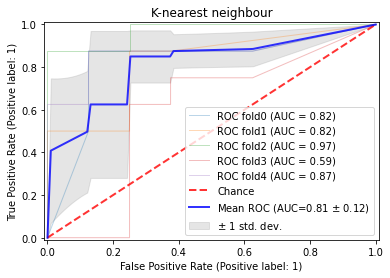

In [55]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors': range(1,100),
              'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','l1','l2']}


gridN = GridSearchCV(KNeighborsClassifier(), parameters, cv = 5, verbose = 1, n_jobs = -1)
bestN = gridN.fit(Xtr_filtered_S, Y_tr)
display(bestN.best_params_) 
bestN.best_score_

KNN=bestN.best_estimator_

tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
cv = StratifiedKFold(n_splits=5)
fig,ax=plt.subplots()
for i, (train, test) in enumerate(cv.split(Xtr_filtered_S, Y_tr)):
    
    KNN.fit(Xtr_filtered_S[train],Y_tr.iloc[list(train)].values.ravel())
    vis=plot_roc_curve(KNN, Xtr_filtered_S[test],Y_tr.iloc[list(test)], name='ROC fold{}'.format(i),alpha=0.3,lw=1,ax=ax)
   
    tprs.append(np.interp(mean_fpr, vis.fpr, vis.tpr))
    tprs[-1][0]=0.0
    aucs.append(vis.roc_auc)
   
ax.plot([0,1],[0,1],linestyle='--', lw=2, color='r', label = 'Chance', alpha = 0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1]=1
mean_auc=auc(mean_fpr,mean_tpr)
std_auc=np.std(aucs)
ax.plot(mean_fpr,mean_tpr,color='b', label=r'Mean ROC (AUC=%0.2f $\pm$ %0.2f)' %(mean_auc,std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper,color='grey',alpha= 0.2, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01,1.01],ylim=[-0.01,1.01],title="K-nearest neighbour")
ax.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 13 candidates, totalling 65 fits


C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'var_smoothing': 0.01}

C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\e0998126.NUSSTU\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is depre

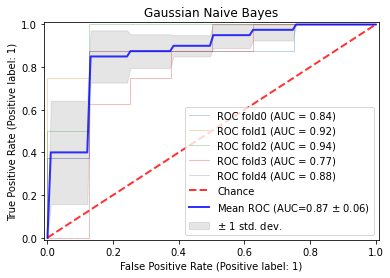

In [64]:
from sklearn.naive_bayes import GaussianNB

parameters = {'var_smoothing': np.logspace(-2, 10, 13),}


gridG = GridSearchCV(GaussianNB(), parameters, cv = 5, verbose = 1, n_jobs = -1)
bestG = gridG.fit(Xtr_filtered_S, Y_tr)
display(bestG.best_params_) 
bestG.best_score_

GNB=bestG.best_estimator_

tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
cv = StratifiedKFold(n_splits=5)
fig,ax=plt.subplots()
for i, (train, test) in enumerate(cv.split(Xtr_filtered_S, Y_tr)):
    
    GNB.fit(Xtr_filtered_S[train],Y_tr.iloc[list(train)].values.ravel())
    vis=plot_roc_curve(GNB, Xtr_filtered_S[test],Y_tr.iloc[list(test)], name='ROC fold{}'.format(i),alpha=0.3,lw=1,ax=ax)
   
    tprs.append(np.interp(mean_fpr, vis.fpr, vis.tpr))
    tprs[-1][0]=0.0
    aucs.append(vis.roc_auc)
   
ax.plot([0,1],[0,1],linestyle='--', lw=2, color='r', label = 'Chance', alpha = 0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1]=1
mean_auc=auc(mean_fpr,mean_tpr)
std_auc=np.std(aucs)
ax.plot(mean_fpr,mean_tpr,color='b', label=r'Mean ROC (AUC=%0.2f $\pm$ %0.2f)' %(mean_auc,std_auc), lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper,color='grey',alpha= 0.2, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.01,1.01],ylim=[-0.01,1.01],title="Gaussian Naive Bayes")
ax.legend(loc="lower right")
plt.show()

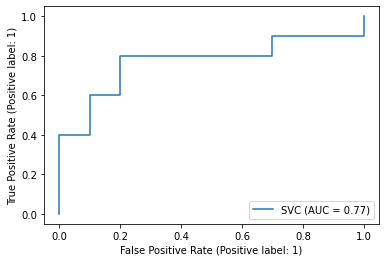

Accuracy = 0.7000
Precision = 0.7500
Recall = 0.6000
Specificity = 0.8000
False positive rate = 0.2000
F1-score = 0.6667
Confusion matrix (%):
[[40. 10.]
 [20. 30.]]


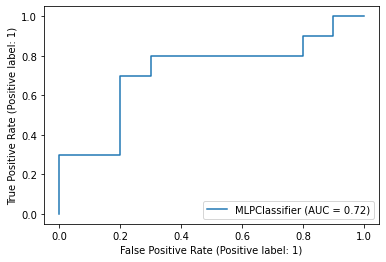

Accuracy = 0.7500
Precision = 0.7778
Recall = 0.7000
Specificity = 0.8000
False positive rate = 0.2000
F1-score = 0.7368
Confusion matrix (%):
[[40. 10.]
 [15. 35.]]


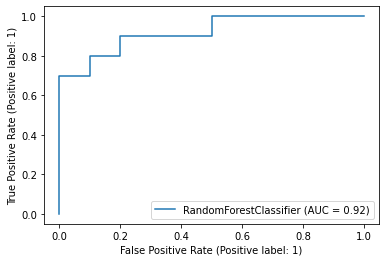

Accuracy = 0.8000
Precision = 0.7500
Recall = 0.9000
Specificity = 0.7000
False positive rate = 0.3000
F1-score = 0.8182
Confusion matrix (%):
[[35. 15.]
 [ 5. 45.]]


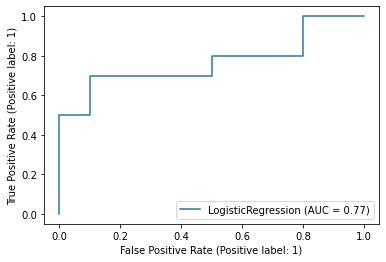

Accuracy = 0.5500
Precision = 0.5333
Recall = 0.8000
Specificity = 0.3000
False positive rate = 0.7000
F1-score = 0.6400
Confusion matrix (%):
[[15. 35.]
 [10. 40.]]


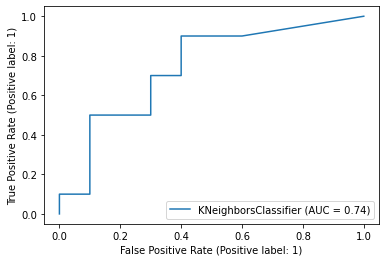

Accuracy = 0.6500
Precision = 0.7143
Recall = 0.5000
Specificity = 0.8000
False positive rate = 0.2000
F1-score = 0.5882
Confusion matrix (%):
[[40. 10.]
 [25. 25.]]


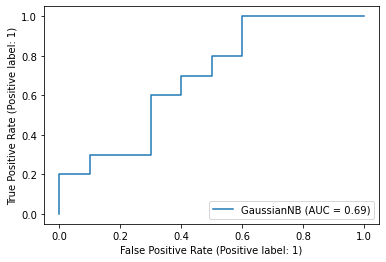

Accuracy = 0.6000
Precision = 1.0000
Recall = 0.2000
Specificity = 1.0000
False positive rate = 0.0000
F1-score = 0.3333
Confusion matrix (%):
[[50.  0.]
 [40. 10.]]


In [65]:
X_TEST=X_val[['ENSG00000255823.5','ENSG00000087086.15','ENSG00000163736.4','ENSG00000205542.11','ENSG00000163191.6',
      'ENSG00000163220.11','ENSG00000075624.17']]
#,'ENSG00000131149.19','ENSG00000131002.12'
XTEST_S = transformer.transform(X_TEST)

SVM_pred = clfSVC.predict(XTEST_S)
RocCurveDisplay.from_estimator(clfSVC,XTEST_S,Y_val)
ax.set(title="SVM (poly)")

plt.show()
cmat = confusion_matrix(Y_val, SVM_pred)
printPerformance(cmat)

MLP_pred = mlp.predict(XTEST_S)
RocCurveDisplay.from_estimator(mlp,XTEST_S,Y_val)
ax.set(title="MLP")
plt.show()
cmat = confusion_matrix(Y_val, MLP_pred)
printPerformance(cmat)

RF_pred = bestF.predict(XTEST_S)
RocCurveDisplay.from_estimator(bestF,XTEST_S,Y_val)
ax.set(title="Random Forest")
plt.show()
cmat = confusion_matrix(Y_val, RF_pred)
printPerformance(cmat)

LogReg_pred = LogReg.predict(XTEST_S)
RocCurveDisplay.from_estimator(LogReg,XTEST_S,Y_val)
ax.set(title="Logistic Regression")
plt.show()
cmat = confusion_matrix(Y_val, LogReg_pred)
printPerformance(cmat)

KNN_pred = KNN.predict(XTEST_S)
RocCurveDisplay.from_estimator(KNN,XTEST_S,Y_val)
ax.set(title="K Nearest Neighbour")
plt.show()
cmat = confusion_matrix(Y_val, KNN_pred)
printPerformance(cmat)

GNB_pred = GNB.predict(XTEST_S)
RocCurveDisplay.from_estimator(GNB,XTEST_S,Y_val)
ax.set(title="Gaussian Naive Bayes")
plt.show()
cmat = confusion_matrix(Y_val, GNB_pred)
printPerformance(cmat)
